In [1]:
import tensorflow as tf
import numpy as np
from bptt import BPTT
import matplotlib.pyplot as plt
from tensorflow.python import debug as tf_debug
%load_ext autotime
%matplotlib inline 

In [2]:
tf.reset_default_graph()

time: 1.77 ms


In [3]:
class PhysicalNet: 
    
    def __init__(self, layer_sizes, input_size, first_input, output_size, keep_prob = 0.9, stddev = 0.001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.output_size = output_size
        self.first_input = first_input
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.intermediate_outputs = [self.first_input]
        
        self.init_weights()
        self.init_biases()
        self.define_inter_outputs()
        
    def init_weights(self):
        for i in range(self.nb_layers):
            if i == 0:
                W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size], stddev = self.stddev))
            elif i != (self.nb_layers - 1):
                W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]], stddev = self.stddev))
            else:
                W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]], stddev = self.stddev))
                
            self.Weights.append(W)
            
    def init_biases(self):
        for i in range(self.nb_layers):
            B = tf.Variable(tf.random_normal([self.layer_sizes[i], 1], stddev = self.stddev))
            self.Biases.append(B)
            
    def define_inter_outputs(self): ## ADD THE DROPOUTS !!!
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            x = self.intermediate_outputs[i]
            if i != (self.nb_layers - 1):
                o = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                o = tf.nn.softmax(tf.matmul(W, x) + b)
                
            self.intermediate_outputs.append(o)
            

time: 49.9 ms


In [4]:
class CommunicationNet: ## ADD THE MEMORY !! 
    
    def __init__(self, layer_sizes, input_size, first_input, memory, keep_prob = 0.9, memory_size = 32,
                 stddev_epsilon = 0.35, output_size = 256, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.memory_size = memory_size
        self.stddev_epsilon = stddev_epsilon
        self.output_size = output_size
        self.first_input = first_input
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.Variable(tf.random_normal([self.layer_sizes[(self.nb_layers-1)], self.memory_size]
                                                            ,stddev = self.stddev))
        self.intermediate_outputs = [first_input]
        self.memory = memory
        
        self.init_weights()    
        self.init_biases()
        self.define_inter_outputs()
        self.def_delta_mem()
        
        
    def init_weights(self):
        for i in range(self.nb_layers):
            if i == 0:
                W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size], stddev = self.stddev))
            elif i != (self.nb_layers - 1):
                W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]],stddev = self.stddev))
            else:
                W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]],stddev = self.stddev))
            self.Weights.append(W)
            
    def init_biases(self):
        for i in range(self.nb_layers):
            B = tf.Variable(tf.random_normal([self.layer_sizes[i], 1],stddev = self.stddev))
            self.Biases.append(B)
            
    def define_inter_outputs(self): ## ADD THE DROPOUTS !!!
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            x = self.intermediate_outputs[i]
            if i != (self.nb_layers - 1):
                o = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                o = tf.nn.softmax(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, self.memory) + b)
                
            self.intermediate_outputs.append(o)
        
    def def_delta_mem(self):
        self.W_mem = tf.Variable(tf.random_normal(shape =[self.memory_size,self.output_size],stddev = self.stddev))
        self.b_mem = tf.Variable(tf.random_normal(shape = [self.memory_size, 1],stddev = self.stddev))
        self.output_mem = tf.add(tf.matmul(self.W_mem, self.intermediate_outputs[-1]),self.b_mem)
        

time: 76.9 ms


In [5]:
class LastNet: ## ADD THE MEMORY !! The memory initialization is random ==> set it 0
    
    def __init__(self, layer_sizes, input_size, first_input, memory, keep_prob = 0.9, memory_size = 32, 
                 stddev_epsilon = 0.35, output_size = 24, stddev = 0.0001):
        self.nb_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.input_size = input_size
        self.memory_size = memory_size
        self.stddev_epsilon = stddev_epsilon
        self.output_size = output_size
        self.first_input = first_input
        self.stddev = stddev
        
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.Variable(tf.random_normal([self.output_size, self.memory_size],stddev = self.stddev))
        self.intermediate_outputs = [self.first_input]
        self.memory = memory
        
        self.init_weights()    
        self.init_biases()
        self.define_inter_outputs()
        self.def_delta_mem()
        
        
    def init_weights(self):
        for i in range(self.nb_layers):
            if i == 0:
                W = tf.Variable(tf.random_normal([self.layer_sizes[i], self.input_size],stddev = self.stddev))
            elif i != (self.nb_layers - 1):
                W = tf.Variable(tf.random_normal([self.layer_sizes[(i+1)], self.layer_sizes[i]],stddev = self.stddev))
            else:
                W = tf.Variable(tf.random_normal([self.output_size, self.layer_sizes[i]],stddev = self.stddev))
            self.Weights.append(W)
            
    def init_biases(self):
        for i in range(self.nb_layers):
            if i != (self.nb_layers - 1):
                B = tf.Variable(tf.random_normal([self.layer_sizes[i+1], 1],stddev = self.stddev))
            else:
                B = tf.Variable(tf.random_normal([self.output_size, 1], stddev = self.stddev))
                
            self.Biases.append(B)
            
    def define_inter_outputs(self): ## ADD THE DROPOUTS !!! REMOVE THE SOFTMAX OF THE LAST LAYER !!!
        for i in range(self.nb_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            x = self.intermediate_outputs[i]
            if i != (self.nb_layers - 1):
                o = tf.nn.dropout(tf.nn.elu(tf.matmul(W, x) + b), keep_prob = 0.9)
            else:
                o = tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, self.memory) + b
                
            self.intermediate_outputs.append(o)
        
    def def_delta_mem(self):
        self.W_mem = tf.Variable(tf.random_normal(shape =[self.memory_size,self.output_size],stddev = self.stddev))
        self.b_mem = tf.Variable(tf.random_normal(shape = [self.memory_size, 1],stddev = self.stddev))
        self.output_mem = tf.add(tf.matmul(self.W_mem, self.intermediate_outputs[-1]),self.b_mem)
        
    def get_output(self):
        return self.intermediate_outputs[-1]
        

time: 83.7 ms


In [6]:
class Policy_Phys:
    
    def __init__(self, nb_agent, nb_landmark, list_phys_tensors, hidden_layer_size = 256, env_dim = 2, 
                 batch_size = 1024, stddev_phys_output = 0.0001):
        self.stddev_phys_output = stddev_phys_output
        self.batch_size = batch_size
        self.env_dim = env_dim
        self.nb_agent = nb_agent
        self.nb_landmark = nb_landmark
        self.hidden_layer_size = hidden_layer_size

        self.phys_tensors = list_phys_tensors
        self.networks_phys = []
        self.PhiX = None
        
        self.init_all()
        
    def init_phys_modules(self):
        with tf.variable_scope("physical") as scope:
            self.networks_phys.append(PhysicalNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                                  self.env_dim, 
                                                  self.phys_tensors[0],
                                                 self.hidden_layer_size))
        for i in range(1, (self.nb_agent + self.nb_landmark)):
            with tf.variable_scope("physical", reuse = True):
                self.networks_phys.append(PhysicalNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size],
                                                      self.env_dim,
                                                      self.phys_tensors[i],
                                                     self.hidden_layer_size))

    def init_PhiX(self):
        list_outputs = []
        for net in self.networks_phys:
            list_outputs.append(tf.reshape(net.intermediate_outputs[-1], [256, -1, 1]))

        all_phys_output = tf.concat(list_outputs, axis = 2)
        self.PhiX = tf.reduce_max(tf.nn.softmax(all_phys_output, dim = -1), axis = 2)

    def init_all(self):
        self.init_phys_modules()
        self.init_PhiX()







time: 38.9 ms


In [7]:
class Policy_Utterance:
    
    def __init__(self, nb_agent, list_utter_tensors, list_mem_tensors, goal_size, vocabulary_size = 20, 
                 hidden_layer_size = 256, memory_size = 32, temperature = 1, batch_size = 1024,
                 stddev_phys_output = 0.0001):
        self.size_goal = goal_size
        self.nb_agent = nb_agent
        self.stddev_phys_output = stddev_phys_output
        self.batch_size = batch_size
        self.temperature = temperature
        self.memory_size = memory_size
        self.vocabulary_size = vocabulary_size
        self.hidden_layer_size = hidden_layer_size
        self.goal = tf.placeholder(tf.float32, [self.size_goal, None])
        self.memory_last = tf.placeholder(tf.float32, [self.memory_size, None])
        
        self.com_tensors = list_utter_tensors
        self.mem_tensors = list_mem_tensors
        self.delta_mem = []
        self.networks_com = []

        self.PhiC = None
        self.init_all()
        

    def init_com_modules(self):## Les poids seront les mêmes pour tous les agents
        with tf.variable_scope("communication") as scope:
            self.networks_com.append(CommunicationNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                                 self.vocabulary_size, self.com_tensors[0], 
                                                      self.mem_tensors[0]))
        for i in range(1, self.nb_agent):
            with tf.variable_scope("communication", reuse=True):
                self.networks_com.append(CommunicationNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                                 self.vocabulary_size,self.com_tensors[i],
                                                          self.mem_tensors[i]))

    def init_delta_mem_tensors(self):
        for i in range(self.nb_agent):
            self.delta_mem.append(self.networks_com[i].output_mem)
            
    def init_PhiC(self):
        list_outputs = []
        for net in self.networks_com:
            list_outputs.append(tf.reshape(net.intermediate_outputs[-1], [256, -1, 1]))

        all_comm_output = tf.concat(list_outputs, axis = 2)
        self.PhiC = tf.reduce_max(tf.nn.softmax(all_comm_output, dim = -1), axis = 2) 

    def init_all(self):
        self.init_com_modules()
        self.init_delta_mem_tensors()
        self.init_PhiC()


time: 52.7 ms


In [8]:
class Policy_Last:
    
    def __init__(self, PhiX, PhiC, goal, memory, hidden_layer_size = 256, 
                 size_goal = 8, memory_size = 32, batch_size = 1024, stddev_phys_output = 0.0001, vocabulary_size = 20,
                env_dim = 2, temperature = 1):
        self.temperature = temperature
        self.stddev_phys_output = stddev_phys_output
        self.env_dim = env_dim
        self.vocabulary_size = vocabulary_size 
        self.batch_size = batch_size
        self.memory_size = memory_size
        self.hidden_layer_size = hidden_layer_size
        self.size_goal = size_goal
        self.goal = goal
        self.memory_last = memory
        self.Phi = None 
        self.PhiX = PhiX
        self.PhiC = PhiC 
        self.delta_mem = []
        self.init_all()

    def init_Phi(self):
        self.Phi = tf.concat([self.PhiC, self.goal, self.PhiX], axis = 0)

    def init_last_module(self):
        inp_size = (2*self.hidden_layer_size + self.size_goal)
        out_size = self.vocabulary_size + 2*self.env_dim
        self.last_net = LastNet([self.hidden_layer_size, self.hidden_layer_size, self.hidden_layer_size], 
                                inp_size, self.Phi, self.memory_last, output_size = out_size)
        
    def init_output(self):
        self.output = self.last_net.get_output()

    def init_all(self):
        self.init_Phi()
        self.init_last_module()
        self.init_output()
        self.init_sample_utterances()
        self.init_sample_phys()
        self.init_delta_mem_tensors()

    def init_sample_utterances(self):## Vérifier qu'on prend un bon slice sur l'output
        u = -tf.log(-tf.log(tf.random_uniform(shape = [self.vocabulary_size, self.batch_size],dtype=tf.float32)))
        utterance_output = tf.slice(self.output, [2*self.env_dim, 0], [self.vocabulary_size, self.batch_size])
        gumbel = tf.exp((utterance_output + u)/self.temperature)
        denoms = tf.reduce_sum(gumbel, axis = 0)
        self.utterance = gumbel/denoms  
        
    def init_sample_phys(self):
        u = tf.random_normal(shape = [2*self.env_dim, self.batch_size],dtype=tf.float32, stddev = self.stddev_phys_output)
        self.output = tf.add(tf.slice(self.output, [0, 0], [2*self.env_dim, self.batch_size]), u)
        self.sample_move = tf.slice(self.output, [0, 0], [self.env_dim, self.batch_size])
        self.sample_gaze  = tf.slice(self.output, [self.env_dim, 0], [self.env_dim, self.batch_size])

    def init_delta_mem_tensors(self):
        self.delta_mem.append(self.last_net.output_mem)
            
    


time: 68.8 ms


In [9]:
class Policy:# Two memories per Agent: one for the communication module, the other one for the last module. Is it correct ?

    def __init__(self,nb_agent, nb_landmark, list_phys_tensors, list_utter_tensors, list_mem_tensors, 
                 list_mem_tensors_last, list_goal_tensors, goal_size, vocabulary_size = 20, hidden_layer_size = 256, 
                 memory_size = 32, temperature = 1, batch_size = 1024, stddev_phys_output = 0.01, env_dim = 2):
        self.nb_agent = nb_agent
        self.goal_size = goal_size
        self.nb_landmark = nb_landmark
        self.list_phys_tensors =  list_phys_tensors
        self.list_utter_tensors = list_utter_tensors
        self.list_mem_tensors = list_mem_tensors
        self.list_goal_tensors = list_goal_tensors
        
        self.phys_module = Policy_Phys(self.nb_agent, self.nb_landmark, self.list_phys_tensors)
        self.utterance_module = Policy_Utterance(self.nb_agent, self.list_utter_tensors, self.list_mem_tensors, 
                                                 self.goal_size)
        
        self.list_last_nets = []
        self.list_utterance = []
        self.list_move = []
        self.list_gaze = []
        
        self.list_delta_mem_comm = self.utterance_module.delta_mem
        self.list_delta_mem_last = []
        self.list_outputs = []
        
        self.init_all()
        
    def init_last_nets(self):### KEEP THE SAME SCOPE IN ORDER TO SHARE THE WEIGHTS !
        for i in range(self.nb_agent):
            with tf.variable_scope("last_net", reuse = (i!=0)):
                self.list_last_nets.append(Policy_Last(self.phys_module.PhiX, self.utterance_module.PhiC, 
                                                   self.list_goal_tensors[i], self.list_mem_tensors[i]))
            
            
    def init_output_list(self):
        for i in range(self.nb_agent):
            self.list_utterance.append(self.list_last_nets[i].utterance)
            self.list_move.append(self.list_last_nets[i].sample_move)
            self.list_gaze.append(self.list_last_nets[i].sample_gaze)
            self.list_delta_mem_last.append(self.list_last_nets[i].delta_mem)
            
    def init_all(self):
        self.init_last_nets()
        self.init_output_list()
            
            
    

time: 46 ms


In [10]:
class Agent:
    
    def __init__(self, name, name_target, bp, pos, v, gaze, goal_location, goal_type, col,
                 vocabulary_size = 20, batch_size = 1024, env_dim = 2, goal_size = 8, 
                 memory_size = 32, time_delta = 0.1, nb_actions = 3, damping_coeff = 0.5):
        self.damping_coeff = damping_coeff
        self.goal_type = goal_type
        self.nb_actions = nb_actions
        self.name_target = name_target
        self.time_delta = tf.constant([time_delta])
        self.env_dim = env_dim
        self.memory_size = memory_size
        self.name = name
        self.goal_size = goal_size
        self.batch_size = batch_size
        self.bp = bp
        self.vocabulary_size = vocabulary_size
        
        with tf.variable_scope("agent" + str(self.name)):
            self.pos = self.bp.get_past_variable(variable_name = "pos_" + str(self.name), starting_value = np.float32(pos)) 
            self.velocity = self.bp.get_past_variable("velocity_" + str(self.name), np.float32(v)) 
            self.gaze = self.bp.get_past_variable("gaze_" + str(self.name), np.float32(gaze))
            self.utterance = self.bp.get_past_variable("utterance_" + str(self.name), 
                                                       np.float32(np.zeros([self.vocabulary_size, self.batch_size])))

            self.memory = self.bp.get_past_variable("memory_" + str(self.name), np.float32(np.zeros([self.memory_size, 
                                                                                             self.batch_size])))

            self.memory_last = self.bp.get_past_variable("memory_last_" + str(self.name), np.float32(
                np.zeros([self.memory_size, self.batch_size])))

            self.tensor_goal_location = tf.constant(goal_location, tf.float32, name = "goal_funcking_agent")
            self.tensor_goal_type = tf.constant(goal_type, tf.float32)
            self.col = tf.constant(col, tf.float32)
        
    #def reset_init_var(self, pos, velocity, gaze, goal_location, goal_type)
    def take_step(self, list_positions, list_utterances, list_mem_comm, list_deltamem_comm, list_mem_last,
              list_detlamem_last, goal, session):
        feed_dict_all = self.create_feed_dict(list_positions, list_utterances, list_mem_comm, list_deltamem_comm, 
                list_mem_last, list_detlamem_last, goal)
        return session.run([self.utterances, self.sample_move], feed_dict = feed_dict_all) 

    def get_move(self):
        return self.p.sample_move
    
    def get_utterance(self):
        return self.p.utterance
    
    def compute_reward_agent(self,goal_agent_pos, goal_agent_gaze, output_velocity, output_gaze): ## Modifier la norme u, il s'agit de l'output
        #du réseau, non pas de la position !
        with tf.name_scope("reward_computation"):
            r1 = tf.reshape(tf.square(tf.norm(goal_agent_pos - self.tensor_goal_location, axis = 0)), [1, self.batch_size])
            r2 = tf.reshape(tf.square(tf.norm(goal_agent_gaze - self.tensor_goal_location, axis = 0)), [1, self.batch_size])
            utt_norm = tf.square(tf.norm(self.new_utterance, axis = 0))
            u_norm = tf.square(tf.norm(tf.concat([output_velocity, output_gaze], axis = 0), axis = 0))
            vec = tf.concat([r1, r2, tf.zeros([1,self.batch_size], tf.float32)], axis = 0)
            v1 = tf.reduce_sum(tf.multiply(vec, self.tensor_goal_type), axis = 0)
            r = -(v1) # + utt_norm + u_norm)
        return r
            
    def compute_new_state(self, tensor_utterance, tensor_velocity, tensor_gaze, tensor_memory_delta, 
                          tensor_memory_last):
        ## ADD THE FORCES TO THE NEW VELOCITY !!
        ## ADD GAUSSIAN NOISE TO THE MEMORY UPDATE !
        with tf.variable_scope("compute_new_state_agent" + str(self.name)):
            self.new_pos = self.bp.name_variable(variable_name = "pos_" + str(self.name), 
                                            v = self.pos + tf.multiply(self.velocity,self.time_delta))
            
            self.new_velocity = self.bp.name_variable("velocity_" + str(self.name), 
                                            (tf.multiply(self.velocity, self.damping_coeff) + 
                                                      tf.multiply(tensor_velocity, self.time_delta)))
            self.new_gaze = self.bp.name_variable("gaze_" + str(self.name), tensor_gaze)
            self.new_memory = self.bp.name_variable("memory_" + str(self.name), self.memory + tensor_memory_delta)
            self.new_memory_last = self.bp.name_variable("memory_last_" + str(self.name), self.memory_last + tensor_memory_last)
            self.new_utterance = self.bp.name_variable("utterance_" + str(self.name), tensor_utterance)

                                            
    def get_position(self):
        return self.pos
    
    def get_velocity(self):
        return self.velocity
    
    def get_gaze(self):
        return self.gaze

    def get_utterance(self):
        return self.utterance
                                        
    def get_memory(self):
        return self.memory
    
    def get_memory_last(self):
        return self.memory_last
    
    def get_phys_state(self):
        return (self.get_position(), self.get_velocity(), self.get_gaze(), self.get_col)
    
    def get_name_target(self):
        return self.name_target
    
    def get_goal(self, other_ags):
        other_agents = [other_ags[i].get_color() for i in self.name_target[0, :]]
        colors = tf.concat(other_agents, axis = 1)
        return tf.concat([self.tensor_goal_type, self.tensor_goal_location, colors], axis = 0)
          
    def get_all_iterations_variables(self):
        return self.pos, self.velocity, self.gaze, self.utterance, self.memory, self.memory_last
    
    def get_color(self):
        return self.col


time: 302 ms


In [11]:
class Environment:
    # Use this class to instantiate an environment on N batches. All batches share the same structure, but not not the
    # same goals.
    def __init__(self, bp, nb_agents = 3, nb_landmarks = 0, env_dim = 2, batch_size = 1024, goal_type_size = 3):
        self.env_dim = env_dim
        self.batch_size = batch_size
        self.goal_type_size = goal_type_size
        self.goal_size = self.goal_type_size + 3 + self.env_dim
        self.nb_agents = nb_agents
        self.nb_landmarks = nb_landmarks
        self.list_agents = []
        self.list_phys_tensors = []
        self.list_utter_tensors = []
        self.list_mem_tensors = []
        self.list_mem_last_tensors = []
        self.list_goals_tensors = []
        self.bp = bp
        
    def init_agents(self):
        for i in range(self.nb_agents):
            ag = Agent(name = i, name_target = self.name_of_targets[i], bp = self.bp, 
                       pos = self.p[i], v = self.v[i], gaze = self.g[i], goal_location = self.gl[i], 
                       goal_type = self.go[i], col = self.co[i])
            self.list_agents.append(ag)
            self.list_phys_tensors.append(ag.get_position())
            self.list_utter_tensors.append(ag.get_utterance())
            self.list_mem_tensors.append(ag.get_memory())
            self.list_mem_last_tensors.append(ag.get_memory_last())
            
    def init_goals_tensors(self):
        for ag in self.list_agents: 
            self.list_goals_tensors.append(ag.get_goal(self.list_agents))
     
    def init_policy(self):
        self.policy = Policy(self.nb_agents, self.nb_landmarks, self.list_phys_tensors, self.list_utter_tensors, 
                            self.list_mem_tensors, self.list_mem_last_tensors, self.list_goals_tensors, self.goal_size)
        
    def init_new_agents_states(self):
        for i in range(self.nb_agents):
            ag = self.list_agents[i]
            tens_utterance = self.policy.list_utterance[i]
            tens_velocity = self.policy.list_move[i]
            tens_gaze = self.policy.list_gaze[i]
            tens_mem_delta = self.policy.list_delta_mem_comm[i]
            tens_mem_delta_last = self.policy.list_delta_mem_last[i]
            ag.compute_new_state(tens_utterance, tens_velocity, tens_gaze, tens_mem_delta, tens_mem_delta_last)
         

    def init_reward_agents(self): ## Check the shuffle for the pos of agent and gaze is OK !!
        rewards = []
        ag_positions = []
        ag_gazes = []
        ag_goal_on_agent = []
        ag_velocities = []
        for i,agent in enumerate(self.list_agents):
            ag_positions.append(agent.new_pos)
            ag_gazes.append(agent.new_gaze)
            ag_velocities.append(self.policy.list_move[i])
            
        agent_positions = tf.stack(ag_positions, axis = 2)
        agent_gazes = tf.stack(ag_gazes, axis = 2)
        agent_velocities = tf.stack(ag_velocities, axis = 2)
        
        for i in range(self.nb_agents):
            agent = self.list_agents[i]
            name_target = agent.get_name_target()[0, :]
            l1 = [[0, k, j] for k,j in enumerate(name_target)]
            l2 = [[1, k, j] for k,j in enumerate(name_target)]
            l3 = [l1, l2]
            #position_target = tf.reshape(tf.concat([tf.slice(agent_positions, [0, k, j], [self.env_dim, 1, 1])
            #                              for k,j in enumerate(name_target)], axis = 1), 
            #                             [self.env_dim, self.batch_size])
            self.position_target = tf.gather_nd(agent_positions, l3)
            self.gaze_target = tf.gather_nd(agent_gazes, l3)
            
            #gaze_target = tf.reshape(tf.concat([tf.slice(agent_gazes, [0, k, j], [self.env_dim, 1, 1])
            #                              for k,j in enumerate(name_target)], axis = 1), 
            #                             [self.env_dim, self.batch_size])  
            
            self.own_velocity = tf.reshape(tf.slice(agent_velocities, [0, 0, i], [self.env_dim, self.batch_size, 1]), 
                                         [self.env_dim, self.batch_size])  
            
            self.own_gaze = tf.reshape(tf.slice(agent_gazes, [0, 0, i], [self.env_dim, self.batch_size, 1]), 
                                         [self.env_dim, self.batch_size])            
            
            reward_agent = agent.compute_reward_agent(self.position_target, self.gaze_target, self.own_velocity,
                                                      self.own_gaze)
            rewards.append(reward_agent)
          
        
        self.rewards_batch = tf.reduce_mean(tf.concat(rewards, axis = 0), axis = 0)
                
    def get_all_iteration_var(self):
        return [tensor for ag in self.list_agents for tensor in ag.get_all_iterations_variables()]
    
    def get_reward_batch(self):
        return self.rewards_batch
    
    def get_position_batch(self):
        return [ag.new_pos for ag in self.list_agents]
    
    def random_env_init(self):
        self.name_of_targets = []
        self.p = []
        self.v = []
        self.g = []
        self.go = []
        self.co = []
        self.gl = []
        for i in range(self.nb_agents):
            self.name_of_targets.append(np.random.randint(0, self.nb_agents, (1, self.batch_size)))
            #self.p.append(np.transpose(np.array([[0,0] for i in range(self.batch_size)])))
            self.p.append(np.random.uniform(0, 3000, [2, self.batch_size]))
            #self.gl.append(np.transpose(np.array([[0.5,0.5] for i in range(self.batch_size)])))
            self.gl.append(np.random.uniform(0, 3000, [2, self.batch_size]))
            self.v.append(np.zeros([self.env_dim, self.batch_size]))
            self.g.append(np.zeros([self.env_dim, self.batch_size]))
            self.go.append(np.transpose(np.array([[1,0, 0] for i in range(self.batch_size)])))
            self.co.append(np.random.uniform(0, 255, [3, 1]))
            
        
        self.init_agents()
        self.init_goals_tensors()
        self.init_policy()
        self.init_new_agents_states()
        self.init_reward_agents()    
        

time: 359 ms


In [26]:
class Experiment:
    
    def __init__(self, time_horizon, batch_size = 1024):
        self.bp = BPTT()
        self.time_horizon = time_horizon
        self.list_rewards = []
        self.batch_size = batch_size
        tf.reset_default_graph()
            
    def instantiate_graph(self, bp, depth_type):## ADD THE AUXILIARY REWARDS !!!!!
        self.env = Environment(self.bp, nb_agents = 1)
        self.env.random_env_init()
        return ([self.env.get_reward_batch()] + self.env.get_position_batch())
    
    def instantiate_both_graphs(self):
        self.graphs = self.bp.generate_graphs(self.instantiate_graph, self.time_horizon)
        
    def train_batch(self, sess):
        self.list_rewards = []
        self.list_distances = []
        self.list_last_pos = []
        
        self.list_t1 = []
        self.list_t2 = []
        last_pos = self.graphs["deep"][-1][1]
        last_coord = tf.reduce_mean(last_pos, axis = 1)
        with tf.name_scope("return"):
            mean_reward = tf.reduce_sum([v[0] for v in self.graphs["deep"]])
            
        self.last_distance = tf.norm(last_pos - tf.constant(self.env.gl[0], tf.float32), axis = 0)
        mean_last_distance = tf.reduce_mean(self.last_distance)
        optimizer = tf.train.RMSPropOptimizer(0.0001)
        step = optimizer.minimize(-mean_reward)
        print("Initializing")
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        print("Creating dict")
        frame_dict = self.bp.generate_feed_dict("deep", [], 0)
        print("Start running")
        for i in range(50):
            t1 = tf.get_default_graph().get_tensor_by_name('unrolled_model/unroll_1/communication/Variable_2:0')
            t2 = tf.get_default_graph().get_tensor_by_name('unrolled_model/unroll_2/communication/Variable_2:0')
            #state_vars = self.bp.generate_output_definitions(self.bp.DEEP)
            results = sess.run([step, mean_reward, mean_last_distance, last_coord, t1, t2]
                                       , feed_dict = frame_dict)
            #sess.run([step], feed_dict = frame_dict)
            #self.bp.save_output_state(self.bp.DEEP, results[-len(state_vars):])
            self.list_rewards.append(results[1])
            self.list_distances.append(results[2])
            self.list_last_pos.append(results[3])
            self.list_t1.append(results[4])
            self.list_t2.append(results[5])
            if i % 10 == 0:
                print("Reward after iteration " + str(i) + ": " + str(results[1]))
                print("Distance after iteration " + str(i) + ": " + str(results[2]))
                print("Last position after iteration " + str(i) + ": (" + str(results[3][0]) + "," + str(results[3][1]) + ")" )
                  
        return self.list_rewards, self.list_distances, self.list_last_pos
    

time: 72.7 ms


In [320]:
state_vars = exp.bp.generate_output_definitions("deep")

time: 1.2 ms


In [297]:
state_vars

[<tf.Tensor 'unrolled_model/unroll_99/last_net/Slice_3:0' shape=(2, 1024) dtype=float32>,
 <tf.Tensor 'unrolled_model/unroll_99/compute_new_state_agent0/add_2:0' shape=(32, 1024) dtype=float32>,
 <tf.Tensor 'unrolled_model/unroll_99/compute_new_state_agent0/add_3:0' shape=(1, 32, 1024) dtype=float32>,
 <tf.Tensor 'unrolled_model/unroll_99/compute_new_state_agent0/add:0' shape=(2, 1024) dtype=float32>,
 <tf.Tensor 'unrolled_model/unroll_99/last_net/truediv_1:0' shape=(20, 1024) dtype=float32>,
 <tf.Tensor 'unrolled_model/unroll_99/compute_new_state_agent0/add_1:0' shape=(2, 1024) dtype=float32>]

time: 8.21 ms


In [27]:
exp = Experiment(5)

time: 2.86 ms


In [28]:
exp.instantiate_both_graphs()
#train_writer = tf.summary.FileWriter('train',
#                                      tf.get_default_graph())

time: 5.56 s


In [233]:
t1 = tf.get_default_graph().get_tensor_by_name('unrolled_model/unroll/communication/Variable_2:0')
t2 = tf.get_default_graph().get_tensor_by_name('unrolled_model/unroll_1/communication/Variable_2:0')

time: 1.77 ms


In [263]:
#init_op = tf.global_variables_initializer()
#with tf.Session() as sess:
    #sess.run(init_op)
u1, u2 = sess.run([tf.get_default_graph().get_tensor_by_name('unrolled_model/unroll/communication/Variable_2:0'), 
                   tf.get_default_graph().get_tensor_by_name('unrolled_model/unroll_1/communication/Variable_2:0')])

time: 13 ms


In [335]:
f = [1, 2, 3, 4]
f[-2:]
sess.close()

time: 1.72 ms


In [29]:
sess = tf.Session()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#sess.add_tensor_filter("has_inf_or_nan", tf_debug.has_inf_or_nan)
l_r, l_d, l_p = exp.train_batch(sess)
sess.close()

Initializing
Creating dict
Start running
Reward after iteration 0: -1.49468e+07
Distance after iteration 0: 1576.45
Last position after iteration 0: (1543.58,1483.19)
Are equals:[[  2.66268635e-05   1.96885048e-05   7.27374500e-05 ...,  -9.50461908e-05
   -2.35462750e-04  -6.05426430e-05]
 [ -1.61551914e-04  -5.62814057e-06  -1.69284118e-04 ...,   2.83751324e-05
   -9.37375735e-05  -3.15652833e-05]
 [  8.60372675e-05  -1.23854465e-04   1.24164231e-04 ...,  -1.09724162e-04
    5.71223973e-05  -3.59780242e-05]
 ..., 
 [  1.50659660e-04  -3.68026485e-05  -1.44206031e-04 ...,  -9.13394251e-05
   -4.78399998e-05  -5.06026809e-05]
 [ -4.64961558e-05   5.22243536e-05  -6.54895339e-05 ...,  -3.63551953e-05
   -8.65251877e-06  -1.37406329e-04]
 [  1.43958736e-04  -4.60578958e-05   1.36857823e-04 ...,   4.49998588e-05
   -2.92278651e-06   1.36149893e-05]]
Reward after iteration 10: -1.49468e+07
Distance after iteration 10: 1576.45
Last position after iteration 10: (1543.58,1483.19)
Are equals:[[

KeyboardInterrupt: 

time: 29.2 s


In [30]:
exp.list_t1[0]

array([[  2.66268635e-05,   1.96885048e-05,   7.27374500e-05, ...,
         -9.50461908e-05,  -2.35462750e-04,  -6.05426430e-05],
       [ -1.61551914e-04,  -5.62814057e-06,  -1.69284118e-04, ...,
          2.83751324e-05,  -9.37375735e-05,  -3.15652833e-05],
       [  8.60372675e-05,  -1.23854465e-04,   1.24164231e-04, ...,
         -1.09724162e-04,   5.71223973e-05,  -3.59780242e-05],
       ..., 
       [  1.50659660e-04,  -3.68026485e-05,  -1.44206031e-04, ...,
         -9.13394251e-05,  -4.78399998e-05,  -5.06026809e-05],
       [ -4.64961558e-05,   5.22243536e-05,  -6.54895339e-05, ...,
         -3.63551953e-05,  -8.65251877e-06,  -1.37406329e-04],
       [  1.43958736e-04,  -4.60578958e-05,   1.36857823e-04, ...,
          4.49998588e-05,  -2.92278651e-06,   1.36149893e-05]], dtype=float32)

time: 5.72 ms


In [31]:
exp.list_t2[0]

array([[ -1.25116348e-04,  -4.68354483e-05,   8.77744023e-05, ...,
          3.45649678e-05,  -5.17923654e-05,   5.76513739e-05],
       [ -1.33135050e-04,  -1.86977661e-04,  -9.04240369e-06, ...,
         -4.44671605e-05,   7.39274983e-05,  -3.71854076e-05],
       [  8.02755603e-05,   2.41237904e-05,   7.15486822e-05, ...,
          3.53181531e-05,   3.05973626e-05,   1.29564447e-04],
       ..., 
       [  8.47822230e-05,  -2.21755654e-05,   1.52262937e-05, ...,
         -1.28498850e-05,  -1.38971227e-04,  -9.37885779e-05],
       [ -1.39696611e-04,  -9.38816156e-05,   7.95670348e-05, ...,
          6.00705062e-05,   3.72034856e-06,   2.03403015e-05],
       [ -1.25432445e-04,   1.69412715e-06,   1.82534077e-05, ...,
          6.09394774e-05,   7.20703683e-05,   3.40152983e-05]], dtype=float32)

time: 4.72 ms


In [80]:
l1 = [[0, k, j] for k,j in enumerate(name_target)]
l2 = [[1, k, j] for k,j in enumerate(name_target)]
l3 = [l1, l2]

time: 3.25 ms


In [81]:
rewards = []
ag_positions = []
ag_gazes = []
ag_goal_on_agent = []
ag_velocities = []
for i,agent in enumerate(exp.env.list_agents):
    ag_positions.append(agent.get_position())
    ag_gazes.append(exp.env.policy.list_gaze[i])
    ag_velocities.append(exp.env.policy.list_move[i])
    
agent_positions = tf.stack(ag_positions, axis = 2)
agent_gazes = tf.stack(ag_gazes, axis = 2)
agent_velocities = tf.stack(ag_velocities, axis = 2)

position_target = tf.gather_nd(agent_positions, l3)

time: 29.7 ms


In [45]:
import pandas as pd
#df = pd.DataFrame({"A":l_r})

time: 2.08 ms


/Users/ducrocqgabriel/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=50,center=False).mean()
  if __name__ == '__main__':


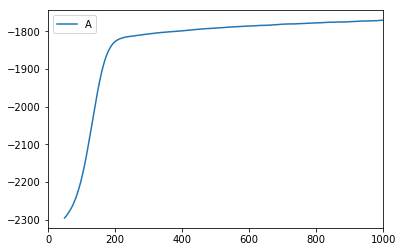

time: 170 ms


In [127]:
pd.rolling_mean(df, 50).plot()

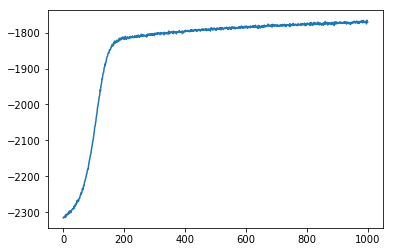

time: 142 ms


In [128]:
plt.plot(l_r)
plt.show()

In [141]:
exp.mean_dist

AttributeError: 'Experiment' object has no attribute 'mean_dist'

time: 6.53 ms


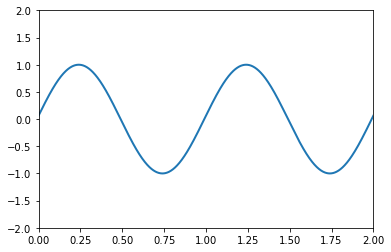

time: 8.38 s


In [180]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [208]:
[v[1] for v in exp.graphs["deep"]]

[[<tf.Tensor 'unrolled_model/unroll/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_1/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_2/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_3/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_4/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_5/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_6/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_7/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_8/add:0' shape=(2, 1024) dtype=float32>],
 [<tf.Tensor 'unrolled_model/unroll_9/add:0' shape=(2, 1024) dtype=float32>]]

time: 3.19 ms


/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=1,center=False).mean()
  app.launch_new_instance()


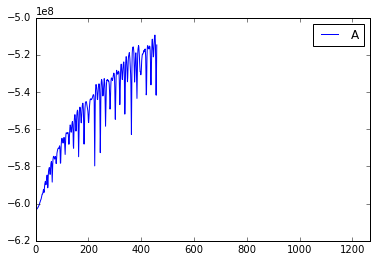

time: 3.36 s


In [337]:
import pandas as pd
d_loss = pd.DataFrame({"A":exp.list_rewards})
pd.rolling_mean(d_loss, 1).plot()

/Users/gabrielducrocq/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


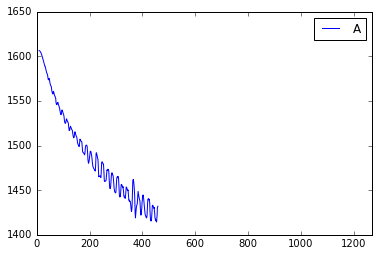

time: 1.13 s


In [338]:
d_distance = pd.DataFrame({"A":exp.list_distances})
pd.rolling_mean(d_distance, 10).plot()

In [339]:
x = [l[0] for l in exp.list_last_pos]
y = [l[1] for l in exp.list_last_pos]

time: 368 ms


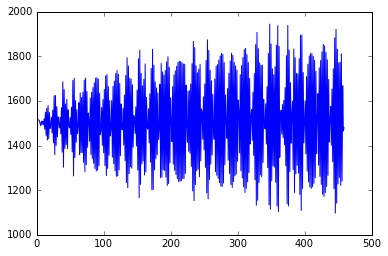

time: 617 ms


In [340]:
plt.plot(x)
plt.show()

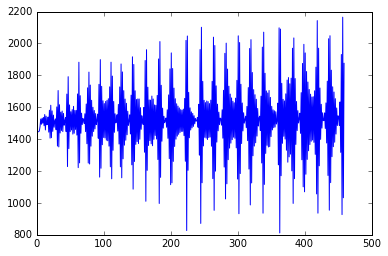

time: 566 ms


In [341]:
plt.plot(y)
plt.show()

In [51]:
y

[-2.2958116e-06,
 9.467356e-06,
 2.0522149e-05,
 3.1006573e-05,
 4.2094634e-05,
 5.3634874e-05,
 6.6518522e-05,
 7.987085e-05,
 9.5443305e-05,
 0.00011218048,
 0.00013123931,
 0.0001524719,
 0.00017628376,
 0.00020300706,
 0.00023276889,
 0.00026559035,
 0.00030192279,
 0.00034205173,
 0.00038596528,
 0.00043371142,
 0.00048528492,
 0.00054148689,
 0.00060065562,
 0.00066483958,
 0.00073214795,
 0.00080441998,
 0.00088042946,
 0.0009605505,
 0.0010433106,
 0.0011314519,
 0.001222854,
 0.0013180977,
 0.0014173938,
 0.0015198635,
 0.0016253334,
 0.0017352051,
 0.0018467359,
 0.0019630818,
 0.0020827164,
 0.0022053518,
 0.0023301085,
 0.0024585039,
 0.0025888646,
 0.0027235693,
 0.0028599428,
 0.0029990294,
 0.0031430982,
 0.0032881782,
 0.0034356799,
 0.0035857339,
 0.0037413605,
 0.0038924003,
 0.0040508187,
 0.0042106193,
 0.004371997,
 0.0045336252,
 0.0047002002,
 0.0048660953,
 0.0050310092,
 0.0051996829,
 0.0053723375,
 0.0055422643,
 0.0057098968,
 0.0058846292,
 0.0060534282,
 0

time: 28.3 ms


In [1]:
l = [3, 4, 5]
for i,j in enumerate(l):
    print(i,j)

0 3
1 4
2 5


In [53]:
d_distance

,A
0,1.414216
1,1.414200
2,1.414185
3,1.414169
4,1.414154
5,1.414137
6,1.414120
7,1.414099
8,1.414078
9,1.414056


time: 31.2 ms


In [130]:
np.random.uniform(0, 1, [3, 4])

array([[ 0.17984203,  0.2443496 ,  0.76248284,  0.44477008],
       [ 0.10963578,  0.59599603,  0.76956576,  0.9440511 ],
       [ 0.28078194,  0.42470612,  0.0176243 ,  0.84524506]])

time: 54.9 ms


In [166]:
def init_v(v):
    u = tf.constant(v)
    W = tf.constant([[0], [1]])
    g = tf.matmul(u, W)
    return g

with tf.Session() as sess:
    print(sess.run(init_v([[1, 2]])))
    print(sess.run(init_v([[2, 3]])))

[[2]]
[[3]]
time: 190 ms


In [249]:
tf.__version__

'1.3.0'

time: 14.8 ms


In [97]:
t1 = tf.constant(np.array([[1, 2, 3], [4, 5, 6]]))
t2 = tf.gather_nd(t1, [[[0, 0], [0, 1]], [[1, 0], [1, 1]]])

time: 5.51 ms


In [98]:
with tf.Session() as sess:
    print(sess.run(t2))

[[1 2]
 [4 5]]
time: 1.59 s


In [87]:
np.array(l3).shape

(2, 1024, 3)

time: 4.7 ms


In [36]:

import math
import numpy as np
import random
import sys
import tensorflow as tf
import bptt

# See https://medium.com/@devnag/


# Data parameters: simple one-number-at-a-time for now
input_dimensions = 1
output_dimensions = 1
batch_size = 1

# Model parameters
lstm_width = 5
m = 0.0
s = 0.5
init = tf.random_normal_initializer(m, s)
noise_m = 0.0
noise_s = 0.03

# Optimization parameters
learning_rate = 0.05
beta1 = 0.95
beta2 = .999
epsilon = 1e-3
momentum = 0.4
gradient_clipping = 2.0
unroll_depth = 4
max_reset_loops = 20

# Training parameters
num_training_loops = 3000
num_inference_loops = 100
num_inference_warmup_loops = 1900


def build_lstm_layer(bp, depth_type, layer_index, raw_x, width):
    """
    Build a single LSTM layer (Graves 2013); can be stacked, but send in sequential layer_indexes to scope properly.
    """
    global init, noise_m, noise_s
    # Define variable names
    h_name = "hidden-%s" % layer_index  # Really the 'output' of the LSTM layer
    c_name = "cell-%s" % layer_index
    # raw_x is [input_size, 1]
    input_size = raw_x.get_shape()[0].value
    # Why so serious? Introduce a little anarchy. Upset the established order...
    x = raw_x + tf.random_normal(raw_x.get_shape(), noise_m, noise_s)

    with tf.variable_scope("lstm_layer_%s" % layer_index):

        # Define shapes for all the weights/biases, limited to just this layer (not shared with other layers)
        # Sizes are 'input_size' when mapping x and 'width' otherwise
        W_xi = tf.get_variable("W_xi", [width, input_size], initializer=init)
        W_hi = tf.get_variable("W_hi", [width, width], initializer=init)
        W_ci = tf.get_variable("W_ci", [width, width], initializer=init)
        b_i =  tf.get_variable("b_i",  [width, 1], initializer=init)
        W_xf = tf.get_variable("W_xf", [width, input_size], initializer=init)
        W_hf = tf.get_variable("W_hf", [width, width], initializer=init)
        W_cf = tf.get_variable("W_cf", [width, width], initializer=init)
        b_f =  tf.get_variable("b_f",  [width, 1], initializer=init)
        W_xc = tf.get_variable("W_xc", [width, input_size], initializer=init)
        W_hc = tf.get_variable("W_hc", [width, width], initializer=init)
        b_c =  tf.get_variable("b_c",  [width, 1], initializer=init)
        W_xo = tf.get_variable("W_xo", [width, input_size], initializer=init)
        W_ho = tf.get_variable("W_ho", [width, width], initializer=init)
        W_co = tf.get_variable("W_co", [width, width], initializer=init)
        b_o =  tf.get_variable("b_o",  [width, 1], initializer=init)

        # Retrieve the previous roll-depth's data, with starting random data if first roll-depth.
        h_past = bp.get_past_variable(h_name, np.float32(np.random.normal(m, s, [width, 1])))
        c_past = bp.get_past_variable(c_name, np.float32(np.random.normal(m, s, [width, 1])))

        # Build graph - looks almost like Alex Graves wrote it!
        i = tf.sigmoid(tf.matmul(W_xi, x) + tf.matmul(W_hi, h_past) + tf.matmul(W_ci, c_past) + b_i)
        f = tf.sigmoid(tf.matmul(W_xf, x) + tf.matmul(W_hf, h_past) + tf.matmul(W_cf, c_past) + b_f)
        c = bp.name_variable(c_name, tf.multiply(f, c_past) + tf.multiply(i, tf.tanh(tf.matmul(W_xc, x) + tf.matmul(W_hc, h_past) + b_c)))
        o = tf.sigmoid(tf.matmul(W_xo, x) + tf.matmul(W_ho, h_past) + tf.matmul(W_co, c) + b_o)
        h = bp.name_variable(h_name, tf.multiply(o, tf.tanh(c)))

    return [c, h]


def build_dual_lstm_frame(bp, depth_type):
    """
    Build a dual-layer LSTM followed by standard sigmoid/linear mapping
    """
    global init, input_dimensions, output_dimensions, batch_size, lstm_width

    # I/O DATA
    input_placeholder = tf.placeholder(tf.float32, shape=(input_dimensions, batch_size))
    output_placeholder = tf.placeholder(tf.float32, shape=(output_dimensions, batch_size))

    last_output = input_placeholder
    for layer_index in range(2):
        [_, h] = build_lstm_layer(bp, depth_type, layer_index, last_output, lstm_width)
        last_output = h

    W = tf.get_variable("W", [1, lstm_width], initializer=init)
    b = tf.get_variable("b", [1,1], initializer=init)
    output_result = tf.sigmoid(tf.matmul(W, last_output) + b)

    # return array of whatever you want, but I/O placeholders FIRST.
    return [input_placeholder, output_placeholder, output_result]


def palindrome(step):
    """
    Turn sequential integers into a palindromic sequence (so look-ahead mapping is not a function, but requires state)
    """
    return (5.0 - abs(float(step % 10) - 5.0)) / 10.0


bp = None
sess = None
graphs = None
done = False

# Loop until you get out of a local minimum or you hit max reset loops
for reset_loop_index in range(max_reset_loops):

    # Clean any previous loops
    if reset_loop_index > 0:
        tf.reset_default_graph()

    # Generate unrolled+shallow graphs
    bp = bptt.BPTT()
    graphs = bp.generate_graphs(build_dual_lstm_frame, unroll_depth)

    # Define loss and clip gradients
    error_vec = [[o - p] for [i, p, o] in graphs[bp.DEEP]]
    loss = tf.reduce_mean(tf.square(error_vec))
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon)
    grads = optimizer.compute_gradients(loss)
    clipped_grads = [(tf.clip_by_value(grad, -gradient_clipping, gradient_clipping), var) for grad, var in grads]
    optimizer.apply_gradients(clipped_grads)
    train = optimizer.minimize(loss)

    # Boilerplate initialization
    init_op = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init_op)
    reset = False

    print("=== Training the unrolled model (reset loop %s) ===" % (reset_loop_index))

    for step in range(num_training_loops):
        # 1.) Generate the dictionary of I/O placeholder data
        start_index = step * unroll_depth
        in_data = np.array([palindrome(x) for x in xrange(start_index, start_index + unroll_depth)], dtype=np.float32)
        out_data = np.array([palindrome(x+1) for x in xrange(start_index, start_index + unroll_depth)], dtype=np.float32)

        # 2a.) Generate the working state to send in, along with data to insert into unrolled placeholders
        frame_dict = bp.generate_feed_dict(bp.DEEP, [in_data, out_data], 2)

        # 2b.) Define the output (training/loss) that we'd like to see (optional)
        session_out = [train, loss] + [o for [i, p, o] in graphs[bp.DEEP]]   # calculated output

        # 3.) Define state variables to pull out as well.
        state_vars = bp.generate_output_definitions(bp.DEEP)
        session_out.extend(state_vars)

        # 4.) Execute the graph
        results = sess.run(session_out, feed_dict=frame_dict)

        # 5.) Extract the state for next training loop; need to make sure we have right part of result array
        bp.save_output_state(bp.DEEP, results[-len(state_vars):])  # for simple RNN

        # 6.) Show training progress; reset graph if loss is stagnant.
        if (step % 100) == 0:
            print("Loss: %s => %s (output: %s)" % (step, results[1], [str(x) for x in results[2:-len(state_vars)]]))
            sys.stdout.flush()

            if step >= 1000 and (results[1] > 0.01):
                print("\nResetting; loss (%s) is stagnating after 1k rounds...\n" % (results[1]))
                reset = True
                break  # To next reset loop

    if not reset:
        break

print("=== Evaluating on shallow model ===")

# Copy final deep state from the training loop above to the shallow state.
bp.copy_state_forward()
[in_ph, out_ph, out_out] = graphs[bp.SHALLOW][0]

# Evaluate one step at a time, and burn in first.
for step in range(num_inference_loops + num_inference_warmup_loops):
    # 1.) Convert step to the palindromic sequence (current and look-ahead-by-one)
    in_value = palindrome(step)
    expected_out_value = palindrome(step+1)

    # 2.) Generate the feed dictionary to send in, both I/O data and recurrent variables
    frame_dict = bp.generate_feed_dict(bp.SHALLOW, np.array([[in_value]], np.float32), 1)

    # 3.) Define state variables to pull out
    session_out = [out_out]
    state_vars = bp.generate_output_definitions(bp.SHALLOW)
    session_out.extend(state_vars)

    # 4.) Execute the graph
    results = sess.run(session_out, feed_dict=frame_dict)

    # 5.) Extract/save state variables for the next loop
    bp.save_output_state(bp.SHALLOW, results[-len(state_vars):])

    # 6.) How we doin'?
    if step > num_inference_warmup_loops:
        print("%s: %s => %s actual vs %s expected (diff: %s)" %
              (step, in_value, results[0][0][0], expected_out_value, expected_out_value - results[0][0][0]))
        sys.stdout.flush()



ValueError: None values not supported.

time: 5.98 s


In [38]:
l = tf.get_variables()

AttributeError: module 'tensorflow' has no attribute 'get_variables'

time: 11.1 ms


In [137]:
tf.reset_default_graph()
W = tf.Variable([[0.5, 0.5, 0.5, 0.5] for j in range(4)])
W2 = tf.Variable(tf.random_normal([4, 1]))

def multiplication(x, t):
    return [tf.matmul(x, W), tf.add(t, 1)]
            
def condition(x, t):
    return tf.less(t, 5)

c = tf.constant([[1.0, 1.0, 1.0, 1.0]])
t = tf.constant(1)
o = tf.while_loop(condition, multiplication, [c, t])
output = tf.reshape(o[0][0], [1, 4])
result = tf.square(tf.matmul(output, W2))

optimizer = tf.train.GradientDescentOptimizer(0.0000001)
step = optimizer.minimize(result)
init_op = tf.global_variables_initializer()

time: 149 ms


In [138]:
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(100000):
        o, r, _ = sess.run([output, result, step])
        if i % 10000 == 0:
            print(r)
            print(o)
            print("\n")

[[ 230.17404175]]
[[ 16.  16.  16.  16.]]


[[ 1.09725559]]
[[ 13.50055122  10.91448784  13.02617836  10.29946041]]


[[ 0.01517505]]
[[ 13.54683208  10.74069214  13.03214836  10.07335854]]


[[ 0.00025298]]
[[ 13.55270863  10.7206316   13.03245163  10.04755688]]


[[  8.00554699e-05]]
[[ 13.54986572  10.71809959  13.02971554  10.04230118]]


[[  8.00554699e-05]]
[[ 13.54986572  10.71809959  13.02971554  10.04230118]]


[[  8.00554699e-05]]
[[ 13.54986572  10.71809959  13.02971554  10.04230118]]


[[  8.00554699e-05]]
[[ 13.54986572  10.71809959  13.02971554  10.04230118]]


[[  8.00554699e-05]]
[[ 13.54986572  10.71809959  13.02971554  10.04230118]]


[[  8.00554699e-05]]
[[ 13.54986572  10.71809959  13.02971554  10.04230118]]


time: 2min 22s


In [72]:
o[0]

<tf.Tensor 'strided_slice:0' shape=(4,) dtype=float32>

time: 11.8 ms


In [51]:
with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(r))

10
time: 3.86 s


In [44]:
sess.close()

AttributeError: 'NoneType' object has no attribute 'close'

time: 11.4 ms
